In [8]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F


from lab1_proto import mfcc

from lab2_proto import *
from lab2_tools import *

from lab3_proto import *
from lab3_tools import *

In [9]:
TRAIN_DIR = "tidigits/disc_4.1.1/tidigits/train/"
TEST_DIR = "tidigits/disc_4.2.1/tidigits/test/"
TRAIN_DIR = os.path.relpath(TRAIN_DIR)
TEST_DIR = os.path.relpath(TEST_DIR)

In [10]:
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}

if not os.path.exists("stateList.txt"):
    stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
    with open("stateList.txt", "w") as f:
        for state in stateList:
            f.write(state + "\n")
else:
    with open("stateList.txt", "r") as f:
        stateList = f.read().splitlines()

" ".join(stateList)

'ah_0 ah_1 ah_2 ao_0 ao_1 ao_2 ay_0 ay_1 ay_2 eh_0 eh_1 eh_2 ey_0 ey_1 ey_2 f_0 f_1 f_2 ih_0 ih_1 ih_2 iy_0 iy_1 iy_2 k_0 k_1 k_2 n_0 n_1 n_2 ow_0 ow_1 ow_2 r_0 r_1 r_2 s_0 s_1 s_2 sil_0 sil_1 sil_2 sp_0 t_0 t_1 t_2 th_0 th_1 th_2 uw_0 uw_1 uw_2 v_0 v_1 v_2 w_0 w_1 w_2 z_0 z_1 z_2'

In [11]:
filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)

wordTrans = list(path2info(filename)[2])
" ".join(wordTrans)

'z 4 3'

In [12]:
from prondict import prondict

phoneTrans = words2phones(wordTrans, prondict)
" ".join(phoneTrans)

'sil z iy r ow sp f ao r sp th r iy sil'

In [13]:
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
" ".join(stateTrans)

'sil_0 sil_1 sil_2 z_0 z_1 z_2 iy_0 iy_1 iy_2 r_0 r_1 r_2 ow_0 ow_1 ow_2 sp_0 f_0 f_1 f_2 ao_0 ao_1 ao_2 r_0 r_1 r_2 sp_0 th_0 th_1 th_2 r_0 r_1 r_2 iy_0 iy_1 iy_2 sil_0 sil_1 sil_2'

C:\Users\elioc\AppData\Local\Temp\ipykernel_6848\188807043.py:4: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob'][:-1]),
C:\Users\elioc\AppData\Local\Temp\ipykernel_6848\188807043.py:5: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat'][:-1, :-1])


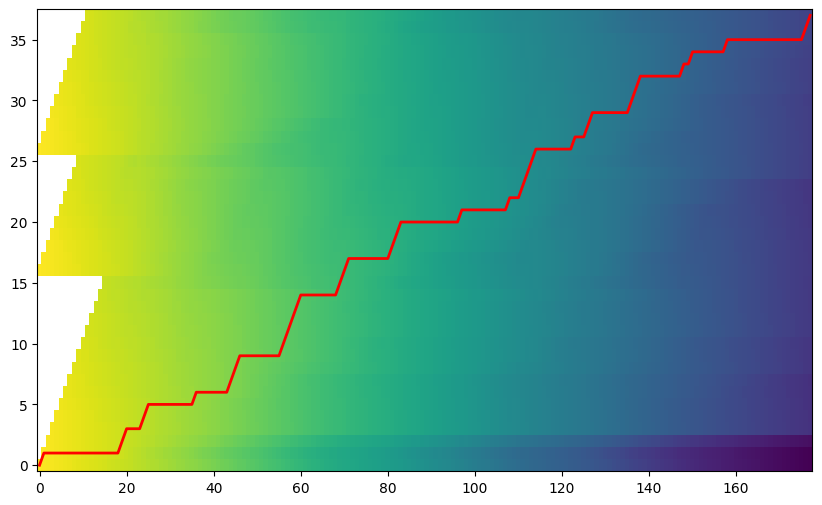

In [14]:
obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
v_loglik, path, log_V = viterbi(
    obsloglik,
    np.log(utteranceHMM['startprob'][:-1]),
    np.log(utteranceHMM['transmat'][:-1, :-1])
)

plt.figure(figsize=(10, 6))
plt.imshow(log_V.T, aspect='auto', interpolation='nearest', origin='lower')
plt.plot(np.arange(len(lmfcc)), path, color='red', linewidth=2)

# Align the state sequence with the MFCC frames using the viterbi path
viterbi_state_trans = [stateTrans[i] for i in path]
aligned = frames2trans(viterbi_state_trans).split("\n")
aligned = [a.split(" ") for a in aligned if a != ""]
aligned = [[float(a[0]), float(a[1]), a[2]] for a in aligned]

In [ ]:
# Plot the MFCC features and the state alignment
plt.figure(figsize=(20, 5))
plt.imshow(lmfcc.T, aspect='auto', origin='lower')

for i, (start, end, state) in enumerate(aligned):
    start = int(start * samplingrate / 200)
    end = int(end * samplingrate / 200)
    plt.axvline(x=start, color='red', linestyle='--', linewidth=0.5)
    plt.axvline(x=end, color='red', linestyle='--', linewidth=0.5)
    plt.text((start + end) / 2, 6 + 2 * (i % 2), state, color='black', fontsize=15, ha='center', va='center')
    
plt.colorbar()
plt.title("MFCC Features")
plt.xlabel("Time (frames)")
plt.ylabel("MFCC Coefficients")

# 4.3 Feature Extraction

In [19]:
from tqdm import tqdm


def make_dataset(folder, phoneHMMs, prondict, output_file="train_data.npz"):
    """
    Extract features from audio files in the given folder and save them to a numpy file.
    """
    data = []
    # Compute total number of files
    total_files = sum([len(files) for _, _, files in os.walk(folder) if files and files[0].endswith(".wav")])
    print(f"Total files to process: {total_files}")

    bar = tqdm(total=total_files, desc="Processing files", unit="file")
    for root, dir, files in os.walk(folder):
        for file in files:
            if file.endswith(".wav"):
                filename = os.path.join(root, file)
                samples, samplingrate = loadAudio(filename)
                lmfcc = mfcc(samples)
                
                wordTrans = list(path2info(filename)[2])
                phoneTrans = words2phones(wordTrans, prondict)
                stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
                
                utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
                
                states = forcedAlignment(
                    lmfcc,
                    utteranceHMM,
                    stateTrans,
                )
                states = [stateList.index(state) for state in states]
                
                data.append({
                    "filename": filename,
                    "lmfcc": lmfcc,
                    "mspec": "mspec",
                    "targets": states,
                })
            bar.update(1)
    bar.close()
    data = np.array(data)
    np.savez(output_file, data=data)



if not os.path.exists("train_data.npz"):
    make_dataset(TRAIN_DIR, phoneHMMs, prondict, output_file="train_data.npz")
if not os.path.exists("test_data.npz"):
    make_dataset(TEST_DIR, phoneHMMs, prondict, output_file="test_data.npz")

train_data = np.load("train_data.npz", allow_pickle=True)["data"]
test_data = np.load("test_data.npz", allow_pickle=True)["data"]

Total files to process: 8623


Processing files: 100%|██████████| 8623/8623 [11:28<00:00, 12.53file/s]


Total files to process: 8700


Processing files: 100%|██████████| 8700/8700 [12:16<00:00, 11.81file/s]


In [21]:
def select_speakers(n, target, speakerID, gender):
    """
    Select all samples from speakers of the target gender until we 
    reach n samples.
    There will likely be more than n samples selected since we select 
    all samples from a speaker.
    """
    unique = np.unique(speakerID[gender == target])
    res = []
    while len(res) < n:
        speaker_idx = np.random.randint(0, len(unique))
        speaker = unique[speaker_idx]
        # get all samples from this speaker
        samples = np.where(speakerID == speaker)
        res.extend(samples[0])
        # remove this speaker from the list of unique speakers
        unique = np.delete(unique, speaker_idx)
    return res

def split_train_val(data, val_size=0.1):
    """
    Split the dataset into training and validation sets.
    Make sure that there is a similar distribution of men and women in both sets, and that each
    speaker is only included in one of the two sets.
    """
    
    filenames = [s["filename"] for s in data]
    gender, speakerID, digits, repetition = zip(*[path2info(f) for f in filenames])
    
    gender, speakerID, digits, repetition = map(np.array, [gender, speakerID, digits, repetition]) 

    # Number of women/men samples
    n_women = np.sum(gender == "woman")
    n_men = len(gender) - n_women
    
    # How many samples to take for validation
    n_val_w = int(val_size * n_women)
    n_val_m = int(val_size * n_men)
    
    val_w = select_speakers(n_val_w, "woman", speakerID, gender)
    val_m = select_speakers(n_val_m, "man", speakerID, gender)

    val_idx = np.concatenate([val_w, val_m])
    train_idx = np.delete(np.arange(len(data)), val_idx)
    
    # Print a summary of the split including the number of samples in each set
    # and the gender distribution in each set
    print(f"Train set: {len(train_idx)} samples")
    print(f"Validation set: {len(val_idx)} samples")
    print(f"Train set gender distribution: {np.sum(gender[train_idx] == 'woman')} women samples, {np.sum(gender[train_idx] == 'man')} men samples")
    print(f"Train set gender distribution: {np.sum(gender[val_idx] == 'woman')} women samples, {np.sum(gender[val_idx] == 'man')} men samples")
    
    return data[train_idx], data[val_idx]
    
    
train_data, val_data = split_train_val(train_data, val_size=0.1)

Train set: 6852 samples
Validation set: 847 samples
Train set gender distribution: 3464 women samples, 3388 men samples
Train set gender distribution: 462 women samples, 385 men samples
